In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

IMG_SIZE = 227  
DATASET_PATH = r"G:\Semester 10\CVPR\CVPR\FINAL\Attendance System - AlexNet\dataset\train"

print("Setup complete")


Setup complete


In [2]:
for student in os.listdir(DATASET_PATH):
    student_path = os.path.join(DATASET_PATH, student)
    if not os.path.isdir(student_path):
        continue 
    
    for img_name in os.listdir(student_path):
        img_path = os.path.join(student_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Skipping unreadable file: {img_path}")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(img_path, img)

print("All images resized to 227x227")

All images resized to 227x227


Gathering images for visualization...


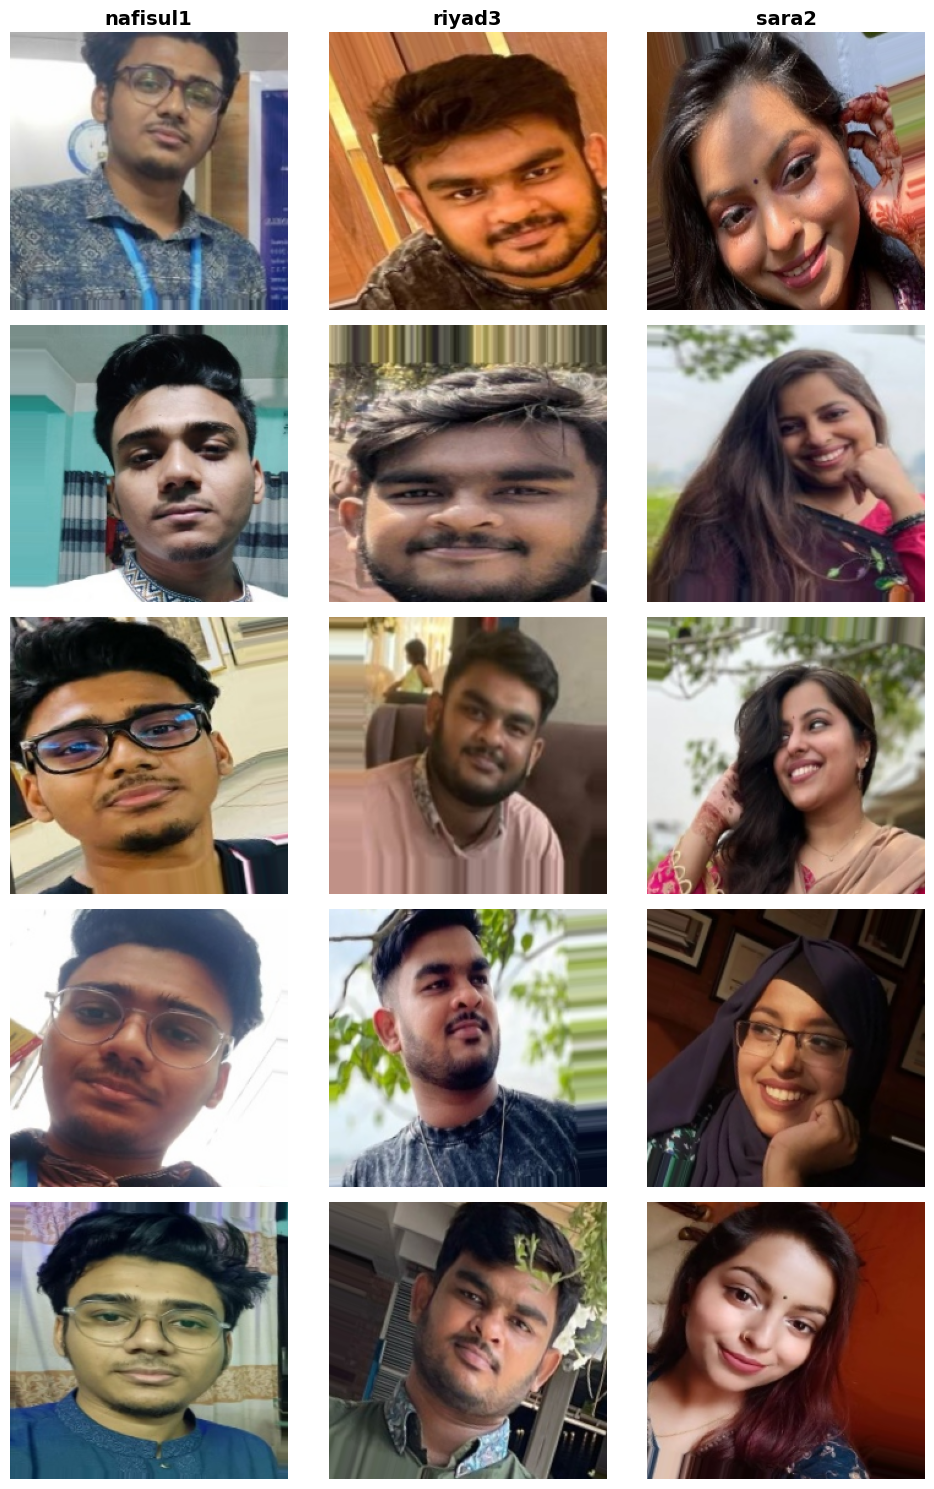

In [13]:
import matplotlib.pyplot as plt
import numpy as np


class_names = list(train_generator.class_indices.keys()) 
num_cols = 3  
num_rows = 5 

sorted_images = {name: [] for name in class_names}

print("Gathering images for visualization...")
while any(len(imgs) < num_rows for imgs in sorted_images.values()):
    x_temp, y_temp = next(train_generator)
    
    for i in range(len(x_temp)):
        idx = np.argmax(y_temp[i])     
        name = list(train_generator.class_indices.keys())[idx] 
        
        if len(sorted_images[name]) < num_rows:
            sorted_images[name].append(x_temp[i])
            
    if all(len(imgs) >= num_rows for imgs in sorted_images.values()):
        break

plt.figure(figsize=(10, 15))

for col_idx, name in enumerate(class_names):
    images = sorted_images[name]
    
    for row_idx in range(num_rows):

        plot_idx = (row_idx * num_cols) + col_idx + 1
        
        plt.subplot(num_rows, num_cols, plot_idx)
        plt.imshow(images[row_idx])
        plt.axis('off')
        
        if row_idx == 0:
            plt.title(name, fontsize=14, fontweight='bold')

            
plt.tight_layout()
plt.show()

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

IMG_SIZE = 227 
num_classes = len(train_generator.class_indices)

model = Sequential()

model.add(Conv2D(96, (11,11), strides=4, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

model.add(Conv2D(256, (5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

model.add(Flatten())

model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25)) 

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50, 
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)

model.save("alexnet_finetuned_attendance_model.h5")
print("Training complete and model saved!")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 13, 13, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_33 (Conv2D)          (None, 13, 13, 384)      

3/3 [==============================] - 2s 857ms/step - loss: 0.6144 - accuracy: 0.7714 - val_loss: 0.7187 - val_accuracy: 0.7500
Epoch 42/50
3/3 [==============================] - 2s 605ms/step - loss: 0.5495 - accuracy: 0.8286 - val_loss: 0.5715 - val_accuracy: 0.7500
Epoch 43/50
3/3 [==============================] - 2s 581ms/step - loss: 0.5409 - accuracy: 0.7429 - val_loss: 0.8672 - val_accuracy: 0.5000
Epoch 44/50
3/3 [==============================] - 2s 953ms/step - loss: 0.5544 - accuracy: 0.6571 - val_loss: 0.8595 - val_accuracy: 0.6250
Epoch 45/50
3/3 [==============================] - 2s 679ms/step - loss: 0.4997 - accuracy: 0.7714 - val_loss: 0.6406 - val_accuracy: 0.7500
Epoch 46/50
3/3 [==============================] - 2s 606ms/step - loss: 0.5742 - accuracy: 0.8000 - val_loss: 0.7482 - val_accuracy: 0.6250
Epoch 47/50
3/3 [==============================] - 2s 596ms/step - loss: 0.4805 - accuracy: 0.8286 - val_loss: 0.7937 - val_accuracy: 0.5000
Epoch 48/50
3/3 [========

In [20]:
model = load_model("alexnet_finetuned_attendance_model.h5")
print("Model loaded!")

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

class_names = {v:k for k,v in train_generator.class_indices.items()}

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        face_img = frame[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))
        face_img = face_img / 255.0
        face_img = np.expand_dims(face_img, axis=0)
        predictions = model.predict(face_img)
        class_idx = np.argmax(predictions[0])
        name = class_names[class_idx]
        cv2.putText(frame, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
    
    cv2.imshow("Attendance System", frame)
    if cv2.waitKey(1) & 0xFF == 27:  
        break

cap.release()
cv2.destroyAllWindows()


Model loaded!
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 71ms/step
